In [8]:
import numpy as np
import xgboost as xgb
import pandas as pd
from IPython.display import display #方便对数据进行可视化
from sklearn.model_selection import train_test_split
import time

In [9]:
def rmspe(y, y_hat):
    #由于sales取了对数，这里要还原
    y = np.exp(y) - 1
    y_hat = np.exp(y_hat) - 1
    
    #由于有yi=0的情况，直接计算会得出无穷大的结果，所以需要处理一下
    #定义一个y_rev来表示y的倒数，y为0时y_rev也赋值为0（因为在项目中提到“ Any day and store with 0 sales is ignored in scoring.“）
    y_rev = np.zeros(y.shape, dtype = float)
    n_zero = y != 0
    y_rev[n_zero] = 1./y[n_zero]

    rmspe = np.sqrt(np.mean(((y - y_hat)*y_rev)**2))
    return rmspe


#自定义一个评价函数

def rmspe_feval(y_hat, dy):
    y = dy.get_label()
    rmspe_score = rmspe(y, y_hat)
    return 'rmspe', rmspe_score
#定义训练函数
def train(param, dtrain, dval, num_round, feval_c):
    train_time = time.clock()

    model = xgb.train(
        param, dtrain, num_round, feval = feval_c, 
        evals = [(dtrain, 'train'), (dval, 'val')], early_stopping_rounds = 100, 
        verbose_eval = True
    )

    train_time = time.clock() - train_time

    print('The training time of the model is: {:.0f}s'.format(train_time))
    
    return model

#定义一个打分函数
def score(bst, dval):
    y_pred = bst.predict(dval)
#print(y_pred)
    y_val = dval.get_label()
    score = rmspe(y_val, y_pred)
#print(score)
    print('The rmspe of the model on validation data set is {:.6f}'.format(score))
    pass

In [10]:
#从头开始处理数据

# 导入训练数据
train_data = pd.read_csv(
    "train.csv", 
    low_memory=False)

store_features = pd.read_csv("store.csv")
# 导入测试数据
test_data = pd.read_csv("test.csv")

#融合
train_data = pd.merge(train_data, store_features, on = 'Store')
test_data = pd.merge(test_data, store_features, on = 'Store')

train_data = train_data.drop('Customers', axis = 1)
sales = train_data['Sales']
features = train_data.drop('Sales', axis = 1)

# 对字符串特征进行独热编码
category = ['StoreType', 'Assortment', 'PromoInterval', 'StateHoliday']


#首先将训练集和测试集合并，然后统一独热编码，然后再拆分为训练集和测试集
features_test = test_data.drop('Id', axis = 1)
data_merge = pd.concat([features, features_test], ignore_index = True)
data_merge_pd = pd.get_dummies(data_merge, columns = category)

# 需要把NA/NAN的数据转化成0
data_merge_pd.fillna(0, inplace = True)

#增加一步，增加‘Year', 'month', 'day'三个有序分类数据

data_merge_pd['year'] = data_merge_pd['Date'].apply(lambda x: float(x.split('-')[0]))
data_merge_pd['month'] = data_merge_pd['Date'].apply(lambda x: float(x.split('-')[1]))
data_merge_pd['day'] = data_merge_pd['Date'].apply(lambda x: float(x.split('-')[2]))
data_merge_pd = data_merge_pd.drop('Date', axis = 1)

#拆分

features_pd = data_merge_pd[0:features.shape[0]]
features_test_pd = data_merge_pd[features.shape[0]:data_merge_pd.shape[0]]

#下面将sales做log处理

sales_log = np.log(train_data['Sales'] + 1) #+1是为了避免log（0）的情况同时使得数据从0开始


X_train, X_val, y_train, y_val = train_test_split(
    features_pd, sales_log, test_size = 0.2, random_state = 1)

dtrain = xgb.DMatrix(X_train, label = y_train)
dval = xgb.DMatrix(X_val, label = y_val)



In [11]:
#设定参数
param = {'max_depth': 10, 'eta': 0.01, 'silent': 0, 'objective': 'reg:linear','min_child_weight': 6,'colsample_bytree': 0.8, 'subsample':0.9}

#设定迭代次数

num_round = 6000
#训练并打分
model = train(param, dtrain, dval, num_round, rmspe_feval)
score(model, dval)



dtest = xgb.DMatrix(features_test_pd)
sales_pred = model.predict(dtest)
sales_pred = np.exp(sales_pred) - 1
closed = (features_test_pd['Open'] == 0).values
sales_pred[closed] = 0
submission = pd.DataFrame({'Id':test_data['Id'], 'Sales': sales_pred})
submission = submission.sort_values(by = 'Id')
submission.to_csv('submit-test.csv', index = False)

[0]	train-rmse:7.46056	val-rmse:7.46389	train-rmspe:0.910866	val-rmspe:0.911281
Multiple eval metrics have been passed: 'val-rmspe' will be used for early stopping.

Will train until val-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.3861	val-rmse:7.38939	train-rmspe:0.910842	val-rmspe:0.911257
[2]	train-rmse:7.31241	val-rmse:7.31566	train-rmspe:0.910816	val-rmspe:0.911232
[3]	train-rmse:7.23943	val-rmse:7.24265	train-rmspe:0.910789	val-rmspe:0.911204
[4]	train-rmse:7.1672	val-rmse:7.17038	train-rmspe:0.91076	val-rmspe:0.911175
[5]	train-rmse:7.09568	val-rmse:7.09883	train-rmspe:0.910728	val-rmspe:0.911144
[6]	train-rmse:7.02488	val-rmse:7.02799	train-rmspe:0.910695	val-rmspe:0.91111
[7]	train-rmse:6.95478	val-rmse:6.95787	train-rmspe:0.910659	val-rmspe:0.911074
[8]	train-rmse:6.88561	val-rmse:6.88867	train-rmspe:0.910621	val-rmspe:0.911036
[9]	train-rmse:6.81691	val-rmse:6.81993	train-rmspe:0.91058	val-rmspe:0.910995
[10]	train-rmse:6.7489	val-rmse:6.75189	train-rmspe:0.910536	

[101]	train-rmse:2.73047	val-rmse:2.73152	train-rmspe:0.862192	val-rmspe:0.862564
[102]	train-rmse:2.70348	val-rmse:2.70452	train-rmspe:0.860728	val-rmspe:0.861098
[103]	train-rmse:2.67675	val-rmse:2.67778	train-rmspe:0.859237	val-rmspe:0.859604
[104]	train-rmse:2.65029	val-rmse:2.6513	train-rmspe:0.857718	val-rmspe:0.858083
[105]	train-rmse:2.62411	val-rmse:2.6251	train-rmspe:0.856169	val-rmspe:0.856532
[106]	train-rmse:2.59819	val-rmse:2.59917	train-rmspe:0.854592	val-rmspe:0.854952
[107]	train-rmse:2.57254	val-rmse:2.5735	train-rmspe:0.852984	val-rmspe:0.853342
[108]	train-rmse:2.54729	val-rmse:2.54823	train-rmspe:0.851355	val-rmspe:0.851711
[109]	train-rmse:2.52214	val-rmse:2.52307	train-rmspe:0.849692	val-rmspe:0.850045
[110]	train-rmse:2.49726	val-rmse:2.49817	train-rmspe:0.847998	val-rmspe:0.848349
[111]	train-rmse:2.47262	val-rmse:2.47352	train-rmspe:0.846279	val-rmspe:0.846627
[112]	train-rmse:2.44821	val-rmse:2.4491	train-rmspe:0.844533	val-rmspe:0.844878
[113]	train-rmse:2.4

[202]	train-rmse:1.02805	val-rmse:1.0281	train-rmspe:0.599512	val-rmspe:0.598744
[203]	train-rmse:1.0184	val-rmse:1.01844	train-rmspe:0.596308	val-rmspe:0.595511
[204]	train-rmse:1.00895	val-rmse:1.00898	train-rmspe:0.593096	val-rmspe:0.592267
[205]	train-rmse:0.999676	val-rmse:0.999706	train-rmspe:0.589897	val-rmspe:0.58904
[206]	train-rmse:0.990425	val-rmse:0.990447	train-rmspe:0.586692	val-rmspe:0.585806
[207]	train-rmse:0.981263	val-rmse:0.981281	train-rmspe:0.583494	val-rmspe:0.582578
[208]	train-rmse:0.972123	val-rmse:0.972131	train-rmspe:0.580308	val-rmspe:0.579357
[209]	train-rmse:0.963131	val-rmse:0.963133	train-rmspe:0.577118	val-rmspe:0.576135
[210]	train-rmse:0.954162	val-rmse:0.954155	train-rmspe:0.573942	val-rmspe:0.572924
[211]	train-rmse:0.945379	val-rmse:0.945365	train-rmspe:0.570758	val-rmspe:0.569713
[212]	train-rmse:0.936655	val-rmse:0.936635	train-rmspe:0.567587	val-rmspe:0.566508
[213]	train-rmse:0.928059	val-rmse:0.928034	train-rmspe:0.564415	val-rmspe:0.563304
[

[301]	train-rmse:0.45001	val-rmse:0.449434	train-rmspe:0.345824	val-rmspe:0.339364
[302]	train-rmse:0.446878	val-rmse:0.446295	train-rmspe:0.344206	val-rmspe:0.337656
[303]	train-rmse:0.443796	val-rmse:0.443207	train-rmspe:0.342615	val-rmspe:0.335981
[304]	train-rmse:0.440708	val-rmse:0.440117	train-rmspe:0.341031	val-rmspe:0.334312
[305]	train-rmse:0.437767	val-rmse:0.437172	train-rmspe:0.339531	val-rmspe:0.332707
[306]	train-rmse:0.434782	val-rmse:0.434181	train-rmspe:0.338009	val-rmspe:0.331097
[307]	train-rmse:0.431918	val-rmse:0.431311	train-rmspe:0.336516	val-rmspe:0.329546
[308]	train-rmse:0.429142	val-rmse:0.428531	train-rmspe:0.335084	val-rmspe:0.328033
[309]	train-rmse:0.426349	val-rmse:0.425732	train-rmspe:0.333642	val-rmspe:0.326498
[310]	train-rmse:0.423492	val-rmse:0.422871	train-rmspe:0.332185	val-rmspe:0.324959
[311]	train-rmse:0.420782	val-rmse:0.420158	train-rmspe:0.330776	val-rmspe:0.323486
[312]	train-rmse:0.417974	val-rmse:0.417343	train-rmspe:0.329359	val-rmspe:0.

[399]	train-rmse:0.278745	val-rmse:0.277744	train-rmspe:0.267888	val-rmspe:0.252656
[400]	train-rmse:0.277974	val-rmse:0.276977	train-rmspe:0.267702	val-rmspe:0.252408
[401]	train-rmse:0.277232	val-rmse:0.276233	train-rmspe:0.2675	val-rmspe:0.252191
[402]	train-rmse:0.276431	val-rmse:0.275427	train-rmspe:0.267269	val-rmspe:0.251891
[403]	train-rmse:0.275728	val-rmse:0.274725	train-rmspe:0.267113	val-rmspe:0.251672
[404]	train-rmse:0.274971	val-rmse:0.273962	train-rmspe:0.266929	val-rmspe:0.251426
[405]	train-rmse:0.274296	val-rmse:0.273286	train-rmspe:0.266827	val-rmspe:0.251257
[406]	train-rmse:0.273211	val-rmse:0.272197	train-rmspe:0.266355	val-rmspe:0.25063
[407]	train-rmse:0.272585	val-rmse:0.271569	train-rmspe:0.266272	val-rmspe:0.250484
[408]	train-rmse:0.271871	val-rmse:0.27085	train-rmspe:0.266113	val-rmspe:0.250263
[409]	train-rmse:0.271253	val-rmse:0.270229	train-rmspe:0.26603	val-rmspe:0.250116
[410]	train-rmse:0.270361	val-rmse:0.269336	train-rmspe:0.265715	val-rmspe:0.2496

[498]	train-rmse:0.231993	val-rmse:0.230834	train-rmspe:0.258146	val-rmspe:0.237669
[499]	train-rmse:0.231852	val-rmse:0.23069	train-rmspe:0.258242	val-rmspe:0.237722
[500]	train-rmse:0.231469	val-rmse:0.230306	train-rmspe:0.258095	val-rmspe:0.237538
[501]	train-rmse:0.230849	val-rmse:0.229685	train-rmspe:0.25773	val-rmspe:0.237107
[502]	train-rmse:0.230541	val-rmse:0.229374	train-rmspe:0.25763	val-rmspe:0.236967
[503]	train-rmse:0.230187	val-rmse:0.229018	train-rmspe:0.257506	val-rmspe:0.236767
[504]	train-rmse:0.230056	val-rmse:0.228887	train-rmspe:0.257604	val-rmspe:0.236819
[505]	train-rmse:0.229893	val-rmse:0.228725	train-rmspe:0.25761	val-rmspe:0.236809
[506]	train-rmse:0.229603	val-rmse:0.228434	train-rmspe:0.257535	val-rmspe:0.236702
[507]	train-rmse:0.229448	val-rmse:0.22828	train-rmspe:0.257573	val-rmspe:0.236718
[508]	train-rmse:0.229308	val-rmse:0.228137	train-rmspe:0.257631	val-rmspe:0.236757
[509]	train-rmse:0.22915	val-rmse:0.227984	train-rmspe:0.25766	val-rmspe:0.236764

[597]	train-rmse:0.214287	val-rmse:0.213146	train-rmspe:0.253369	val-rmspe:0.230905
[598]	train-rmse:0.21414	val-rmse:0.212999	train-rmspe:0.253324	val-rmspe:0.230827
[599]	train-rmse:0.214047	val-rmse:0.21291	train-rmspe:0.253284	val-rmspe:0.230809
[600]	train-rmse:0.213847	val-rmse:0.212711	train-rmspe:0.253068	val-rmspe:0.230604
[601]	train-rmse:0.213799	val-rmse:0.212666	train-rmspe:0.253083	val-rmspe:0.230624
[602]	train-rmse:0.213587	val-rmse:0.212448	train-rmspe:0.25287	val-rmspe:0.230399
[603]	train-rmse:0.213445	val-rmse:0.21231	train-rmspe:0.252803	val-rmspe:0.230322
[604]	train-rmse:0.213307	val-rmse:0.212172	train-rmspe:0.252764	val-rmspe:0.230239
[605]	train-rmse:0.213249	val-rmse:0.212113	train-rmspe:0.252782	val-rmspe:0.230248
[606]	train-rmse:0.213202	val-rmse:0.212068	train-rmspe:0.252783	val-rmspe:0.230261
[607]	train-rmse:0.212928	val-rmse:0.211792	train-rmspe:0.252566	val-rmspe:0.229962
[608]	train-rmse:0.212831	val-rmse:0.211694	train-rmspe:0.25249	val-rmspe:0.2299

[695]	train-rmse:0.199638	val-rmse:0.198561	train-rmspe:0.242017	val-rmspe:0.21857
[696]	train-rmse:0.199433	val-rmse:0.198352	train-rmspe:0.241861	val-rmspe:0.218372
[697]	train-rmse:0.199238	val-rmse:0.198155	train-rmspe:0.241694	val-rmspe:0.218175
[698]	train-rmse:0.199197	val-rmse:0.198117	train-rmspe:0.241645	val-rmspe:0.21816
[699]	train-rmse:0.199178	val-rmse:0.198098	train-rmspe:0.241654	val-rmspe:0.218166
[700]	train-rmse:0.199092	val-rmse:0.198011	train-rmspe:0.241604	val-rmspe:0.218106
[701]	train-rmse:0.198886	val-rmse:0.197802	train-rmspe:0.241424	val-rmspe:0.217899
[702]	train-rmse:0.198784	val-rmse:0.197699	train-rmspe:0.241347	val-rmspe:0.217818
[703]	train-rmse:0.198524	val-rmse:0.197441	train-rmspe:0.241018	val-rmspe:0.217563
[704]	train-rmse:0.198426	val-rmse:0.197343	train-rmspe:0.240943	val-rmspe:0.217486
[705]	train-rmse:0.198157	val-rmse:0.197072	train-rmspe:0.240682	val-rmspe:0.217105
[706]	train-rmse:0.197984	val-rmse:0.196897	train-rmspe:0.240574	val-rmspe:0.2

[794]	train-rmse:0.187921	val-rmse:0.186943	train-rmspe:0.230183	val-rmspe:0.206803
[795]	train-rmse:0.187691	val-rmse:0.186712	train-rmspe:0.229953	val-rmspe:0.206433
[796]	train-rmse:0.187516	val-rmse:0.186535	train-rmspe:0.229804	val-rmspe:0.206254
[797]	train-rmse:0.187424	val-rmse:0.186443	train-rmspe:0.229724	val-rmspe:0.206174
[798]	train-rmse:0.18728	val-rmse:0.1863	train-rmspe:0.229607	val-rmspe:0.206047
[799]	train-rmse:0.187046	val-rmse:0.186066	train-rmspe:0.22937	val-rmspe:0.205776
[800]	train-rmse:0.186997	val-rmse:0.18602	train-rmspe:0.229318	val-rmspe:0.205735
[801]	train-rmse:0.186919	val-rmse:0.185942	train-rmspe:0.229244	val-rmspe:0.205667
[802]	train-rmse:0.18668	val-rmse:0.185701	train-rmspe:0.229007	val-rmspe:0.205397
[803]	train-rmse:0.186624	val-rmse:0.185644	train-rmspe:0.228959	val-rmspe:0.205346
[804]	train-rmse:0.186578	val-rmse:0.185602	train-rmspe:0.228921	val-rmspe:0.205294
[805]	train-rmse:0.186412	val-rmse:0.185436	train-rmspe:0.228762	val-rmspe:0.20512

[893]	train-rmse:0.176327	val-rmse:0.175445	train-rmspe:0.21868	val-rmspe:0.194151
[894]	train-rmse:0.176241	val-rmse:0.175362	train-rmspe:0.218599	val-rmspe:0.194066
[895]	train-rmse:0.176145	val-rmse:0.175267	train-rmspe:0.218523	val-rmspe:0.193971
[896]	train-rmse:0.176105	val-rmse:0.175231	train-rmspe:0.218493	val-rmspe:0.193931
[897]	train-rmse:0.176027	val-rmse:0.175155	train-rmspe:0.218387	val-rmspe:0.193854
[898]	train-rmse:0.175916	val-rmse:0.175047	train-rmspe:0.218312	val-rmspe:0.193736
[899]	train-rmse:0.175851	val-rmse:0.174984	train-rmspe:0.218253	val-rmspe:0.193674
[900]	train-rmse:0.175719	val-rmse:0.174852	train-rmspe:0.218126	val-rmspe:0.193533
[901]	train-rmse:0.175561	val-rmse:0.174688	train-rmspe:0.217977	val-rmspe:0.193358
[902]	train-rmse:0.175526	val-rmse:0.174657	train-rmspe:0.217939	val-rmspe:0.193329
[903]	train-rmse:0.175451	val-rmse:0.174584	train-rmspe:0.217878	val-rmspe:0.193255
[904]	train-rmse:0.175361	val-rmse:0.174499	train-rmspe:0.217793	val-rmspe:0.

[992]	train-rmse:0.167224	val-rmse:0.1665	train-rmspe:0.209679	val-rmspe:0.184144
[993]	train-rmse:0.167158	val-rmse:0.166438	train-rmspe:0.209544	val-rmspe:0.184077
[994]	train-rmse:0.166998	val-rmse:0.16628	train-rmspe:0.209401	val-rmspe:0.183907
[995]	train-rmse:0.166866	val-rmse:0.166151	train-rmspe:0.209271	val-rmspe:0.183765
[996]	train-rmse:0.166799	val-rmse:0.166082	train-rmspe:0.209218	val-rmspe:0.183697
[997]	train-rmse:0.166712	val-rmse:0.165997	train-rmspe:0.209139	val-rmspe:0.183611
[998]	train-rmse:0.166638	val-rmse:0.165921	train-rmspe:0.209089	val-rmspe:0.183468
[999]	train-rmse:0.166553	val-rmse:0.165838	train-rmspe:0.209006	val-rmspe:0.183369
[1000]	train-rmse:0.166429	val-rmse:0.165712	train-rmspe:0.208888	val-rmspe:0.18324
[1001]	train-rmse:0.166304	val-rmse:0.165589	train-rmspe:0.208791	val-rmspe:0.183103
[1002]	train-rmse:0.166228	val-rmse:0.165511	train-rmspe:0.208741	val-rmspe:0.183018
[1003]	train-rmse:0.166159	val-rmse:0.165443	train-rmspe:0.208644	val-rmspe:0

[1089]	train-rmse:0.159823	val-rmse:0.159258	train-rmspe:0.202162	val-rmspe:0.175842
[1090]	train-rmse:0.159789	val-rmse:0.15923	train-rmspe:0.202132	val-rmspe:0.175812
[1091]	train-rmse:0.159767	val-rmse:0.159209	train-rmspe:0.202113	val-rmspe:0.175792
[1092]	train-rmse:0.159655	val-rmse:0.159098	train-rmspe:0.202001	val-rmspe:0.175667
[1093]	train-rmse:0.159577	val-rmse:0.159023	train-rmspe:0.201926	val-rmspe:0.175576
[1094]	train-rmse:0.159453	val-rmse:0.158895	train-rmspe:0.201817	val-rmspe:0.17544
[1095]	train-rmse:0.159384	val-rmse:0.15883	train-rmspe:0.201751	val-rmspe:0.175372
[1096]	train-rmse:0.159298	val-rmse:0.158747	train-rmspe:0.201652	val-rmspe:0.175274
[1097]	train-rmse:0.159244	val-rmse:0.158693	train-rmspe:0.201607	val-rmspe:0.17522
[1098]	train-rmse:0.159171	val-rmse:0.15862	train-rmspe:0.201543	val-rmspe:0.175147
[1099]	train-rmse:0.159139	val-rmse:0.15859	train-rmspe:0.201462	val-rmspe:0.175118
[1100]	train-rmse:0.159104	val-rmse:0.158559	train-rmspe:0.201425	val-r

[1186]	train-rmse:0.152956	val-rmse:0.152548	train-rmspe:0.194702	val-rmspe:0.167987
[1187]	train-rmse:0.152889	val-rmse:0.152483	train-rmspe:0.19464	val-rmspe:0.167901
[1188]	train-rmse:0.152852	val-rmse:0.152447	train-rmspe:0.194606	val-rmspe:0.167864
[1189]	train-rmse:0.152737	val-rmse:0.152328	train-rmspe:0.194518	val-rmspe:0.16775
[1190]	train-rmse:0.152679	val-rmse:0.152273	train-rmspe:0.194427	val-rmspe:0.167685
[1191]	train-rmse:0.152595	val-rmse:0.15219	train-rmspe:0.194312	val-rmspe:0.167588
[1192]	train-rmse:0.152524	val-rmse:0.15212	train-rmspe:0.19426	val-rmspe:0.167507
[1193]	train-rmse:0.152475	val-rmse:0.152074	train-rmspe:0.194203	val-rmspe:0.167458
[1194]	train-rmse:0.152398	val-rmse:0.152001	train-rmspe:0.194131	val-rmspe:0.167384
[1195]	train-rmse:0.152307	val-rmse:0.15191	train-rmspe:0.194045	val-rmspe:0.167281
[1196]	train-rmse:0.15228	val-rmse:0.151886	train-rmspe:0.193912	val-rmspe:0.167256
[1197]	train-rmse:0.152235	val-rmse:0.151843	train-rmspe:0.193872	val-rm

[1283]	train-rmse:0.147393	val-rmse:0.147184	train-rmspe:0.188728	val-rmspe:0.162025
[1284]	train-rmse:0.147308	val-rmse:0.147101	train-rmspe:0.18866	val-rmspe:0.161927
[1285]	train-rmse:0.147254	val-rmse:0.147049	train-rmspe:0.188609	val-rmspe:0.161873
[1286]	train-rmse:0.14723	val-rmse:0.147027	train-rmspe:0.188578	val-rmspe:0.16185
[1287]	train-rmse:0.147161	val-rmse:0.146957	train-rmspe:0.188517	val-rmspe:0.16178
[1288]	train-rmse:0.147128	val-rmse:0.146929	train-rmspe:0.188494	val-rmspe:0.161745
[1289]	train-rmse:0.147111	val-rmse:0.146912	train-rmspe:0.188475	val-rmspe:0.161736
[1290]	train-rmse:0.147085	val-rmse:0.146888	train-rmspe:0.188453	val-rmspe:0.161712
[1291]	train-rmse:0.147048	val-rmse:0.146855	train-rmspe:0.18842	val-rmspe:0.161676
[1292]	train-rmse:0.147024	val-rmse:0.146832	train-rmspe:0.18843	val-rmspe:0.161656
[1293]	train-rmse:0.146969	val-rmse:0.146778	train-rmspe:0.188382	val-rmspe:0.161604
[1294]	train-rmse:0.14692	val-rmse:0.146733	train-rmspe:0.188338	val-rm

[1380]	train-rmse:0.142494	val-rmse:0.142522	train-rmspe:0.183652	val-rmspe:0.156724
[1381]	train-rmse:0.142438	val-rmse:0.142469	train-rmspe:0.183614	val-rmspe:0.156664
[1382]	train-rmse:0.142411	val-rmse:0.142447	train-rmspe:0.183592	val-rmspe:0.156641
[1383]	train-rmse:0.142394	val-rmse:0.14243	train-rmspe:0.183588	val-rmspe:0.156613
[1384]	train-rmse:0.142341	val-rmse:0.142382	train-rmspe:0.183537	val-rmspe:0.156548
[1385]	train-rmse:0.142299	val-rmse:0.142341	train-rmspe:0.1835	val-rmspe:0.156506
[1386]	train-rmse:0.142224	val-rmse:0.142268	train-rmspe:0.183438	val-rmspe:0.156421
[1387]	train-rmse:0.142177	val-rmse:0.14222	train-rmspe:0.183395	val-rmspe:0.156367
[1388]	train-rmse:0.142157	val-rmse:0.142201	train-rmspe:0.183399	val-rmspe:0.15635
[1389]	train-rmse:0.14211	val-rmse:0.142156	train-rmspe:0.183374	val-rmspe:0.156299
[1390]	train-rmse:0.142062	val-rmse:0.142113	train-rmspe:0.183334	val-rmspe:0.156255
[1391]	train-rmse:0.142019	val-rmse:0.142068	train-rmspe:0.183296	val-r

[1477]	train-rmse:0.137808	val-rmse:0.138052	train-rmspe:0.178888	val-rmspe:0.151534
[1478]	train-rmse:0.137787	val-rmse:0.138034	train-rmspe:0.178871	val-rmspe:0.15151
[1479]	train-rmse:0.137736	val-rmse:0.137984	train-rmspe:0.17883	val-rmspe:0.151461
[1480]	train-rmse:0.137689	val-rmse:0.13794	train-rmspe:0.178786	val-rmspe:0.151415
[1481]	train-rmse:0.137626	val-rmse:0.13788	train-rmspe:0.178753	val-rmspe:0.151348
[1482]	train-rmse:0.137603	val-rmse:0.137859	train-rmspe:0.17873	val-rmspe:0.151324
[1483]	train-rmse:0.13759	val-rmse:0.137847	train-rmspe:0.178703	val-rmspe:0.151312
[1484]	train-rmse:0.137568	val-rmse:0.137828	train-rmspe:0.178679	val-rmspe:0.15129
[1485]	train-rmse:0.137533	val-rmse:0.137795	train-rmspe:0.178371	val-rmspe:0.151235
[1486]	train-rmse:0.137495	val-rmse:0.137756	train-rmspe:0.178337	val-rmspe:0.151197
[1487]	train-rmse:0.137454	val-rmse:0.137718	train-rmspe:0.178305	val-rmspe:0.15116
[1488]	train-rmse:0.13743	val-rmse:0.137696	train-rmspe:0.178283	val-rmsp

[1574]	train-rmse:0.133891	val-rmse:0.134348	train-rmspe:0.174307	val-rmspe:0.147277
[1575]	train-rmse:0.133827	val-rmse:0.134286	train-rmspe:0.174242	val-rmspe:0.147202
[1576]	train-rmse:0.133807	val-rmse:0.134268	train-rmspe:0.174224	val-rmspe:0.147185
[1577]	train-rmse:0.133777	val-rmse:0.134245	train-rmspe:0.174163	val-rmspe:0.147155
[1578]	train-rmse:0.133741	val-rmse:0.134212	train-rmspe:0.174133	val-rmspe:0.147119
[1579]	train-rmse:0.1337	val-rmse:0.134172	train-rmspe:0.174094	val-rmspe:0.147022
[1580]	train-rmse:0.133591	val-rmse:0.134064	train-rmspe:0.17399	val-rmspe:0.146912
[1581]	train-rmse:0.133568	val-rmse:0.134045	train-rmspe:0.173972	val-rmspe:0.146892
[1582]	train-rmse:0.133556	val-rmse:0.134034	train-rmspe:0.17392	val-rmspe:0.146881
[1583]	train-rmse:0.133532	val-rmse:0.134015	train-rmspe:0.173713	val-rmspe:0.146861
[1584]	train-rmse:0.133511	val-rmse:0.134001	train-rmspe:0.173581	val-rmspe:0.146838
[1585]	train-rmse:0.133487	val-rmse:0.133981	train-rmspe:0.173557	val

[1671]	train-rmse:0.130641	val-rmse:0.131319	train-rmspe:0.170083	val-rmspe:0.14379
[1672]	train-rmse:0.130605	val-rmse:0.131287	train-rmspe:0.170043	val-rmspe:0.14376
[1673]	train-rmse:0.130595	val-rmse:0.131278	train-rmspe:0.170043	val-rmspe:0.143753
[1674]	train-rmse:0.130578	val-rmse:0.131264	train-rmspe:0.17003	val-rmspe:0.143738
[1675]	train-rmse:0.130528	val-rmse:0.131216	train-rmspe:0.169988	val-rmspe:0.143689
[1676]	train-rmse:0.130485	val-rmse:0.131175	train-rmspe:0.169955	val-rmspe:0.143642
[1677]	train-rmse:0.130453	val-rmse:0.131154	train-rmspe:0.169915	val-rmspe:0.143619
[1678]	train-rmse:0.130367	val-rmse:0.131068	train-rmspe:0.169828	val-rmspe:0.14352
[1679]	train-rmse:0.130342	val-rmse:0.131046	train-rmspe:0.169811	val-rmspe:0.143494
[1680]	train-rmse:0.130299	val-rmse:0.131004	train-rmspe:0.169789	val-rmspe:0.143448
[1681]	train-rmse:0.130283	val-rmse:0.130988	train-rmspe:0.169776	val-rmspe:0.143432
[1682]	train-rmse:0.130238	val-rmse:0.130945	train-rmspe:0.169733	val

[1768]	train-rmse:0.127701	val-rmse:0.128613	train-rmspe:0.167023	val-rmspe:0.140718
[1769]	train-rmse:0.12769	val-rmse:0.128605	train-rmspe:0.167018	val-rmspe:0.140706
[1770]	train-rmse:0.127673	val-rmse:0.128592	train-rmspe:0.166994	val-rmspe:0.140692
[1771]	train-rmse:0.127645	val-rmse:0.128565	train-rmspe:0.166975	val-rmspe:0.140659
[1772]	train-rmse:0.127587	val-rmse:0.128512	train-rmspe:0.166931	val-rmspe:0.140606
[1773]	train-rmse:0.127571	val-rmse:0.128496	train-rmspe:0.166916	val-rmspe:0.140589
[1774]	train-rmse:0.127551	val-rmse:0.128477	train-rmspe:0.1669	val-rmspe:0.140571
[1775]	train-rmse:0.127531	val-rmse:0.128462	train-rmspe:0.166872	val-rmspe:0.140549
[1776]	train-rmse:0.127489	val-rmse:0.128424	train-rmspe:0.166842	val-rmspe:0.140508
[1777]	train-rmse:0.127475	val-rmse:0.128411	train-rmspe:0.166839	val-rmspe:0.140496
[1778]	train-rmse:0.127461	val-rmse:0.128399	train-rmspe:0.16683	val-rmspe:0.140483
[1779]	train-rmse:0.127433	val-rmse:0.128371	train-rmspe:0.166798	val

[1865]	train-rmse:0.125094	val-rmse:0.126243	train-rmspe:0.164868	val-rmspe:0.137876
[1866]	train-rmse:0.125071	val-rmse:0.126221	train-rmspe:0.164848	val-rmspe:0.137851
[1867]	train-rmse:0.125054	val-rmse:0.126207	train-rmspe:0.164839	val-rmspe:0.137837
[1868]	train-rmse:0.124995	val-rmse:0.126149	train-rmspe:0.164784	val-rmspe:0.137768
[1869]	train-rmse:0.124967	val-rmse:0.126124	train-rmspe:0.164761	val-rmspe:0.137746
[1870]	train-rmse:0.124956	val-rmse:0.126113	train-rmspe:0.164752	val-rmspe:0.137735
[1871]	train-rmse:0.124903	val-rmse:0.126063	train-rmspe:0.164709	val-rmspe:0.137684
[1872]	train-rmse:0.124871	val-rmse:0.126032	train-rmspe:0.164683	val-rmspe:0.137653
[1873]	train-rmse:0.124846	val-rmse:0.126011	train-rmspe:0.164662	val-rmspe:0.13762
[1874]	train-rmse:0.12482	val-rmse:0.125993	train-rmspe:0.164634	val-rmspe:0.137604
[1875]	train-rmse:0.124798	val-rmse:0.125972	train-rmspe:0.164614	val-rmspe:0.137584
[1876]	train-rmse:0.124775	val-rmse:0.125951	train-rmspe:0.164596	v

[1962]	train-rmse:0.122528	val-rmse:0.123956	train-rmspe:0.162176	val-rmspe:0.135223
[1963]	train-rmse:0.1225	val-rmse:0.12394	train-rmspe:0.162156	val-rmspe:0.135206
[1964]	train-rmse:0.122476	val-rmse:0.123924	train-rmspe:0.162145	val-rmspe:0.135189
[1965]	train-rmse:0.122461	val-rmse:0.123914	train-rmspe:0.162136	val-rmspe:0.135179
[1966]	train-rmse:0.122431	val-rmse:0.123886	train-rmspe:0.162111	val-rmspe:0.135158
[1967]	train-rmse:0.122405	val-rmse:0.123863	train-rmspe:0.162082	val-rmspe:0.135123
[1968]	train-rmse:0.122386	val-rmse:0.12385	train-rmspe:0.16207	val-rmspe:0.13511
[1969]	train-rmse:0.12237	val-rmse:0.123836	train-rmspe:0.162049	val-rmspe:0.135096
[1970]	train-rmse:0.122348	val-rmse:0.123821	train-rmspe:0.16202	val-rmspe:0.13508
[1971]	train-rmse:0.122326	val-rmse:0.1238	train-rmspe:0.161997	val-rmspe:0.135058
[1972]	train-rmse:0.122307	val-rmse:0.123788	train-rmspe:0.161822	val-rmspe:0.135036
[1973]	train-rmse:0.122298	val-rmse:0.12378	train-rmspe:0.161728	val-rmspe:0

[2059]	train-rmse:0.12046	val-rmse:0.122141	train-rmspe:0.159716	val-rmspe:0.133185
[2060]	train-rmse:0.120442	val-rmse:0.122126	train-rmspe:0.1597	val-rmspe:0.133163
[2061]	train-rmse:0.120421	val-rmse:0.122115	train-rmspe:0.159345	val-rmspe:0.133144
[2062]	train-rmse:0.120417	val-rmse:0.122112	train-rmspe:0.159339	val-rmspe:0.133142
[2063]	train-rmse:0.120404	val-rmse:0.122105	train-rmspe:0.159334	val-rmspe:0.133129
[2064]	train-rmse:0.120389	val-rmse:0.122092	train-rmspe:0.159322	val-rmspe:0.133115
[2065]	train-rmse:0.120363	val-rmse:0.122066	train-rmspe:0.159296	val-rmspe:0.133091
[2066]	train-rmse:0.120347	val-rmse:0.122053	train-rmspe:0.159275	val-rmspe:0.133074
[2067]	train-rmse:0.120336	val-rmse:0.122045	train-rmspe:0.159264	val-rmspe:0.133067
[2068]	train-rmse:0.120311	val-rmse:0.12202	train-rmspe:0.159245	val-rmspe:0.133045
[2069]	train-rmse:0.120291	val-rmse:0.122001	train-rmspe:0.159225	val-rmspe:0.133024
[2070]	train-rmse:0.120275	val-rmse:0.12199	train-rmspe:0.159212	val-

[2156]	train-rmse:0.118584	val-rmse:0.120505	train-rmspe:0.156724	val-rmspe:0.13125
[2157]	train-rmse:0.118563	val-rmse:0.120487	train-rmspe:0.15671	val-rmspe:0.131233
[2158]	train-rmse:0.118542	val-rmse:0.120467	train-rmspe:0.156676	val-rmspe:0.131206
[2159]	train-rmse:0.11852	val-rmse:0.120447	train-rmspe:0.156643	val-rmspe:0.131183
[2160]	train-rmse:0.118506	val-rmse:0.120436	train-rmspe:0.15663	val-rmspe:0.131172
[2161]	train-rmse:0.118483	val-rmse:0.120414	train-rmspe:0.156611	val-rmspe:0.131156
[2162]	train-rmse:0.118457	val-rmse:0.120391	train-rmspe:0.156591	val-rmspe:0.131128
[2163]	train-rmse:0.118439	val-rmse:0.120376	train-rmspe:0.156573	val-rmspe:0.131117
[2164]	train-rmse:0.118423	val-rmse:0.120362	train-rmspe:0.156552	val-rmspe:0.131103
[2165]	train-rmse:0.118407	val-rmse:0.120347	train-rmspe:0.156541	val-rmspe:0.131092
[2166]	train-rmse:0.118402	val-rmse:0.120343	train-rmspe:0.156542	val-rmspe:0.131088
[2167]	train-rmse:0.118388	val-rmse:0.12033	train-rmspe:0.156531	val-

[2253]	train-rmse:0.116898	val-rmse:0.119079	train-rmspe:0.154545	val-rmspe:0.129716
[2254]	train-rmse:0.116887	val-rmse:0.119075	train-rmspe:0.154538	val-rmspe:0.129711
[2255]	train-rmse:0.116876	val-rmse:0.119066	train-rmspe:0.15453	val-rmspe:0.129701
[2256]	train-rmse:0.116862	val-rmse:0.119053	train-rmspe:0.154427	val-rmspe:0.129689
[2257]	train-rmse:0.11685	val-rmse:0.11904	train-rmspe:0.154418	val-rmspe:0.12968
[2258]	train-rmse:0.116837	val-rmse:0.119031	train-rmspe:0.154397	val-rmspe:0.129671
[2259]	train-rmse:0.116801	val-rmse:0.118996	train-rmspe:0.154323	val-rmspe:0.129631
[2260]	train-rmse:0.116786	val-rmse:0.118982	train-rmspe:0.154295	val-rmspe:0.129615
[2261]	train-rmse:0.116771	val-rmse:0.118967	train-rmspe:0.15428	val-rmspe:0.129598
[2262]	train-rmse:0.116756	val-rmse:0.118954	train-rmspe:0.154267	val-rmspe:0.129584
[2263]	train-rmse:0.116742	val-rmse:0.118943	train-rmspe:0.154256	val-rmspe:0.129574
[2264]	train-rmse:0.11673	val-rmse:0.118934	train-rmspe:0.154247	val-r

[2350]	train-rmse:0.115276	val-rmse:0.1177	train-rmspe:0.151888	val-rmspe:0.128093
[2351]	train-rmse:0.115268	val-rmse:0.117693	train-rmspe:0.15188	val-rmspe:0.128087
[2352]	train-rmse:0.115255	val-rmse:0.117682	train-rmspe:0.151866	val-rmspe:0.128075
[2353]	train-rmse:0.115235	val-rmse:0.117661	train-rmspe:0.151844	val-rmspe:0.128057
[2354]	train-rmse:0.115225	val-rmse:0.117651	train-rmspe:0.151547	val-rmspe:0.128059
[2355]	train-rmse:0.115196	val-rmse:0.117625	train-rmspe:0.15151	val-rmspe:0.128024
[2356]	train-rmse:0.115173	val-rmse:0.117604	train-rmspe:0.151492	val-rmspe:0.128003
[2357]	train-rmse:0.115145	val-rmse:0.117575	train-rmspe:0.151463	val-rmspe:0.127971
[2358]	train-rmse:0.115139	val-rmse:0.11757	train-rmspe:0.151458	val-rmspe:0.127965
[2359]	train-rmse:0.115123	val-rmse:0.117562	train-rmspe:0.15144	val-rmspe:0.127954
[2360]	train-rmse:0.115107	val-rmse:0.117551	train-rmspe:0.151467	val-rmspe:0.127943
[2361]	train-rmse:0.115097	val-rmse:0.117543	train-rmspe:0.151455	val-r

[2447]	train-rmse:0.113745	val-rmse:0.116435	train-rmspe:0.149358	val-rmspe:0.126581
[2448]	train-rmse:0.113721	val-rmse:0.116415	train-rmspe:0.14933	val-rmspe:0.12656
[2449]	train-rmse:0.113704	val-rmse:0.1164	train-rmspe:0.149317	val-rmspe:0.126545
[2450]	train-rmse:0.113697	val-rmse:0.116395	train-rmspe:0.149249	val-rmspe:0.126539
[2451]	train-rmse:0.113675	val-rmse:0.116382	train-rmspe:0.149232	val-rmspe:0.126524
[2452]	train-rmse:0.113662	val-rmse:0.116373	train-rmspe:0.149224	val-rmspe:0.126516
[2453]	train-rmse:0.11365	val-rmse:0.116364	train-rmspe:0.149213	val-rmspe:0.126506
[2454]	train-rmse:0.113636	val-rmse:0.116353	train-rmspe:0.149203	val-rmspe:0.126497
[2455]	train-rmse:0.113621	val-rmse:0.116338	train-rmspe:0.149189	val-rmspe:0.126481
[2456]	train-rmse:0.113603	val-rmse:0.116326	train-rmspe:0.149074	val-rmspe:0.126468
[2457]	train-rmse:0.113588	val-rmse:0.116314	train-rmspe:0.149064	val-rmspe:0.126457
[2458]	train-rmse:0.113568	val-rmse:0.116307	train-rmspe:0.149053	val-

[2544]	train-rmse:0.112384	val-rmse:0.115356	train-rmspe:0.147104	val-rmspe:0.125261
[2545]	train-rmse:0.112368	val-rmse:0.115342	train-rmspe:0.147092	val-rmspe:0.125248
[2546]	train-rmse:0.112357	val-rmse:0.115334	train-rmspe:0.146973	val-rmspe:0.125242
[2547]	train-rmse:0.112348	val-rmse:0.115325	train-rmspe:0.146967	val-rmspe:0.125235
[2548]	train-rmse:0.112338	val-rmse:0.115319	train-rmspe:0.146896	val-rmspe:0.125229
[2549]	train-rmse:0.112333	val-rmse:0.115315	train-rmspe:0.146891	val-rmspe:0.125224
[2550]	train-rmse:0.112325	val-rmse:0.115308	train-rmspe:0.146884	val-rmspe:0.125218
[2551]	train-rmse:0.112312	val-rmse:0.115296	train-rmspe:0.146872	val-rmspe:0.125206
[2552]	train-rmse:0.112303	val-rmse:0.115289	train-rmspe:0.146854	val-rmspe:0.125197
[2553]	train-rmse:0.112292	val-rmse:0.115281	train-rmspe:0.146761	val-rmspe:0.125189
[2554]	train-rmse:0.112284	val-rmse:0.115275	train-rmspe:0.146754	val-rmspe:0.12518
[2555]	train-rmse:0.112271	val-rmse:0.115263	train-rmspe:0.146744	

[2641]	train-rmse:0.111178	val-rmse:0.11442	train-rmspe:0.144902	val-rmspe:0.124128
[2642]	train-rmse:0.11117	val-rmse:0.114414	train-rmspe:0.144902	val-rmspe:0.124122
[2643]	train-rmse:0.111156	val-rmse:0.114402	train-rmspe:0.144867	val-rmspe:0.124113
[2644]	train-rmse:0.111148	val-rmse:0.114397	train-rmspe:0.14486	val-rmspe:0.124108
[2645]	train-rmse:0.111139	val-rmse:0.114392	train-rmspe:0.144858	val-rmspe:0.124104
[2646]	train-rmse:0.111126	val-rmse:0.114384	train-rmspe:0.144847	val-rmspe:0.124072
[2647]	train-rmse:0.111113	val-rmse:0.114374	train-rmspe:0.144836	val-rmspe:0.124026
[2648]	train-rmse:0.111099	val-rmse:0.114365	train-rmspe:0.144826	val-rmspe:0.124014
[2649]	train-rmse:0.111092	val-rmse:0.114359	train-rmspe:0.144819	val-rmspe:0.124007
[2650]	train-rmse:0.111087	val-rmse:0.114355	train-rmspe:0.144814	val-rmspe:0.124003
[2651]	train-rmse:0.111068	val-rmse:0.114336	train-rmspe:0.144801	val-rmspe:0.123982
[2652]	train-rmse:0.111062	val-rmse:0.114331	train-rmspe:0.144796	va

[2738]	train-rmse:0.110021	val-rmse:0.113547	train-rmspe:0.143379	val-rmspe:0.123127
[2739]	train-rmse:0.110006	val-rmse:0.113538	train-rmspe:0.143367	val-rmspe:0.123117
[2740]	train-rmse:0.109999	val-rmse:0.113532	train-rmspe:0.143372	val-rmspe:0.12311
[2741]	train-rmse:0.109993	val-rmse:0.113527	train-rmspe:0.143366	val-rmspe:0.123105
[2742]	train-rmse:0.109985	val-rmse:0.113524	train-rmspe:0.143363	val-rmspe:0.123102
[2743]	train-rmse:0.109978	val-rmse:0.11352	train-rmspe:0.143357	val-rmspe:0.123097
[2744]	train-rmse:0.109968	val-rmse:0.113513	train-rmspe:0.143348	val-rmspe:0.123091
[2745]	train-rmse:0.109951	val-rmse:0.1135	train-rmspe:0.143333	val-rmspe:0.12308
[2746]	train-rmse:0.109931	val-rmse:0.113482	train-rmspe:0.143314	val-rmspe:0.123052
[2747]	train-rmse:0.10992	val-rmse:0.113477	train-rmspe:0.143304	val-rmspe:0.123044
[2748]	train-rmse:0.109913	val-rmse:0.113471	train-rmspe:0.143212	val-rmspe:0.123039
[2749]	train-rmse:0.109902	val-rmse:0.113464	train-rmspe:0.143206	val-r

[2835]	train-rmse:0.108906	val-rmse:0.112709	train-rmspe:0.141481	val-rmspe:0.122188
[2836]	train-rmse:0.108898	val-rmse:0.112705	train-rmspe:0.141478	val-rmspe:0.122184
[2837]	train-rmse:0.108889	val-rmse:0.1127	train-rmspe:0.141472	val-rmspe:0.122177
[2838]	train-rmse:0.108881	val-rmse:0.112694	train-rmspe:0.141466	val-rmspe:0.122171
[2839]	train-rmse:0.108873	val-rmse:0.11269	train-rmspe:0.141387	val-rmspe:0.122168
[2840]	train-rmse:0.108864	val-rmse:0.112682	train-rmspe:0.14138	val-rmspe:0.12216
[2841]	train-rmse:0.108856	val-rmse:0.112676	train-rmspe:0.141373	val-rmspe:0.122154
[2842]	train-rmse:0.108846	val-rmse:0.112669	train-rmspe:0.141366	val-rmspe:0.122147
[2843]	train-rmse:0.108831	val-rmse:0.112656	train-rmspe:0.141353	val-rmspe:0.12213
[2844]	train-rmse:0.108821	val-rmse:0.112648	train-rmspe:0.141348	val-rmspe:0.122124
[2845]	train-rmse:0.108818	val-rmse:0.112646	train-rmspe:0.141351	val-rmspe:0.122122
[2846]	train-rmse:0.108804	val-rmse:0.112637	train-rmspe:0.141336	val-r

[2933]	train-rmse:0.107809	val-rmse:0.111895	train-rmspe:0.139969	val-rmspe:0.121229
[2934]	train-rmse:0.107803	val-rmse:0.111891	train-rmspe:0.139968	val-rmspe:0.121226
[2935]	train-rmse:0.107788	val-rmse:0.111878	train-rmspe:0.139954	val-rmspe:0.121216
[2936]	train-rmse:0.107777	val-rmse:0.11187	train-rmspe:0.139948	val-rmspe:0.121212
[2937]	train-rmse:0.107771	val-rmse:0.111866	train-rmspe:0.139943	val-rmspe:0.121208
[2938]	train-rmse:0.107764	val-rmse:0.111859	train-rmspe:0.139929	val-rmspe:0.121202
[2939]	train-rmse:0.107748	val-rmse:0.111851	train-rmspe:0.139913	val-rmspe:0.121191
[2940]	train-rmse:0.107736	val-rmse:0.111844	train-rmspe:0.139904	val-rmspe:0.121183
[2941]	train-rmse:0.107729	val-rmse:0.111839	train-rmspe:0.139634	val-rmspe:0.121158
[2942]	train-rmse:0.107726	val-rmse:0.111836	train-rmspe:0.139631	val-rmspe:0.121156
[2943]	train-rmse:0.107713	val-rmse:0.111825	train-rmspe:0.139537	val-rmspe:0.121145
[2944]	train-rmse:0.107703	val-rmse:0.111822	train-rmspe:0.139532	

[3030]	train-rmse:0.106775	val-rmse:0.111176	train-rmspe:0.137479	val-rmspe:0.120401
[3031]	train-rmse:0.106771	val-rmse:0.111174	train-rmspe:0.137404	val-rmspe:0.120399
[3032]	train-rmse:0.106764	val-rmse:0.111169	train-rmspe:0.137401	val-rmspe:0.120394
[3033]	train-rmse:0.106756	val-rmse:0.111162	train-rmspe:0.137395	val-rmspe:0.120386
[3034]	train-rmse:0.106746	val-rmse:0.111157	train-rmspe:0.13732	val-rmspe:0.120381
[3035]	train-rmse:0.106732	val-rmse:0.111141	train-rmspe:0.13731	val-rmspe:0.12037
[3036]	train-rmse:0.106717	val-rmse:0.111131	train-rmspe:0.13729	val-rmspe:0.120359
[3037]	train-rmse:0.106712	val-rmse:0.111127	train-rmspe:0.137273	val-rmspe:0.120354
[3038]	train-rmse:0.106698	val-rmse:0.111119	train-rmspe:0.13726	val-rmspe:0.120345
[3039]	train-rmse:0.10669	val-rmse:0.111111	train-rmspe:0.137255	val-rmspe:0.120341
[3040]	train-rmse:0.106676	val-rmse:0.111101	train-rmspe:0.137243	val-rmspe:0.120333
[3041]	train-rmse:0.106663	val-rmse:0.111091	train-rmspe:0.137232	val-r

[3127]	train-rmse:0.10582	val-rmse:0.110485	train-rmspe:0.135927	val-rmspe:0.119598
[3128]	train-rmse:0.105812	val-rmse:0.110478	train-rmspe:0.135922	val-rmspe:0.119591
[3129]	train-rmse:0.105801	val-rmse:0.110471	train-rmspe:0.1359	val-rmspe:0.119579
[3130]	train-rmse:0.105797	val-rmse:0.11047	train-rmspe:0.135897	val-rmspe:0.119571
[3131]	train-rmse:0.105781	val-rmse:0.110463	train-rmspe:0.135889	val-rmspe:0.119563
[3132]	train-rmse:0.105775	val-rmse:0.110458	train-rmspe:0.135883	val-rmspe:0.119557
[3133]	train-rmse:0.105769	val-rmse:0.110455	train-rmspe:0.135883	val-rmspe:0.119554
[3134]	train-rmse:0.105765	val-rmse:0.110453	train-rmspe:0.13588	val-rmspe:0.119552
[3135]	train-rmse:0.105752	val-rmse:0.110446	train-rmspe:0.135862	val-rmspe:0.11954
[3136]	train-rmse:0.105749	val-rmse:0.110445	train-rmspe:0.135796	val-rmspe:0.119538
[3137]	train-rmse:0.105741	val-rmse:0.110438	train-rmspe:0.135789	val-rmspe:0.119533
[3138]	train-rmse:0.105735	val-rmse:0.110432	train-rmspe:0.135783	val-r

[3224]	train-rmse:0.10493	val-rmse:0.10991	train-rmspe:0.134405	val-rmspe:0.118913
[3225]	train-rmse:0.104916	val-rmse:0.1099	train-rmspe:0.134389	val-rmspe:0.118904
[3226]	train-rmse:0.104908	val-rmse:0.109898	train-rmspe:0.134387	val-rmspe:0.118902
[3227]	train-rmse:0.104903	val-rmse:0.109894	train-rmspe:0.134378	val-rmspe:0.118896
[3228]	train-rmse:0.104896	val-rmse:0.109892	train-rmspe:0.134375	val-rmspe:0.11889
[3229]	train-rmse:0.104885	val-rmse:0.109883	train-rmspe:0.134366	val-rmspe:0.118882
[3230]	train-rmse:0.104875	val-rmse:0.109877	train-rmspe:0.134359	val-rmspe:0.118867
[3231]	train-rmse:0.104867	val-rmse:0.109871	train-rmspe:0.134359	val-rmspe:0.118861
[3232]	train-rmse:0.104855	val-rmse:0.109865	train-rmspe:0.13435	val-rmspe:0.118854
[3233]	train-rmse:0.104851	val-rmse:0.109863	train-rmspe:0.134347	val-rmspe:0.118851
[3234]	train-rmse:0.104841	val-rmse:0.109855	train-rmspe:0.134338	val-rmspe:0.118829
[3235]	train-rmse:0.104832	val-rmse:0.109849	train-rmspe:0.134332	val-r

[3321]	train-rmse:0.104103	val-rmse:0.109373	train-rmspe:0.132972	val-rmspe:0.118274
[3322]	train-rmse:0.104092	val-rmse:0.109366	train-rmspe:0.13296	val-rmspe:0.118265
[3323]	train-rmse:0.104083	val-rmse:0.109362	train-rmspe:0.132953	val-rmspe:0.11826
[3324]	train-rmse:0.104077	val-rmse:0.109357	train-rmspe:0.132961	val-rmspe:0.118255
[3325]	train-rmse:0.104071	val-rmse:0.109351	train-rmspe:0.132949	val-rmspe:0.118247
[3326]	train-rmse:0.104062	val-rmse:0.109344	train-rmspe:0.132941	val-rmspe:0.11824
[3327]	train-rmse:0.104057	val-rmse:0.109339	train-rmspe:0.133021	val-rmspe:0.118225
[3328]	train-rmse:0.104048	val-rmse:0.109335	train-rmspe:0.133016	val-rmspe:0.118221
[3329]	train-rmse:0.104043	val-rmse:0.10933	train-rmspe:0.133011	val-rmspe:0.118218
[3330]	train-rmse:0.104033	val-rmse:0.109323	train-rmspe:0.133003	val-rmspe:0.118213
[3331]	train-rmse:0.104028	val-rmse:0.109319	train-rmspe:0.132997	val-rmspe:0.118208
[3332]	train-rmse:0.104013	val-rmse:0.10931	train-rmspe:0.132983	val-

[3418]	train-rmse:0.103344	val-rmse:0.108869	train-rmspe:0.131558	val-rmspe:0.117746
[3419]	train-rmse:0.103337	val-rmse:0.108863	train-rmspe:0.131552	val-rmspe:0.117742
[3420]	train-rmse:0.10333	val-rmse:0.108859	train-rmspe:0.131547	val-rmspe:0.117734
[3421]	train-rmse:0.103319	val-rmse:0.108853	train-rmspe:0.13154	val-rmspe:0.117728
[3422]	train-rmse:0.103314	val-rmse:0.10885	train-rmspe:0.13155	val-rmspe:0.117722
[3423]	train-rmse:0.103299	val-rmse:0.108842	train-rmspe:0.131541	val-rmspe:0.117714
[3424]	train-rmse:0.103283	val-rmse:0.108828	train-rmspe:0.131526	val-rmspe:0.1177
[3425]	train-rmse:0.103273	val-rmse:0.108823	train-rmspe:0.131456	val-rmspe:0.117696
[3426]	train-rmse:0.103269	val-rmse:0.10882	train-rmspe:0.131457	val-rmspe:0.117693
[3427]	train-rmse:0.103258	val-rmse:0.108811	train-rmspe:0.131447	val-rmspe:0.117683
[3428]	train-rmse:0.10325	val-rmse:0.108806	train-rmspe:0.131442	val-rmspe:0.117671
[3429]	train-rmse:0.103244	val-rmse:0.1088	train-rmspe:0.131434	val-rmspe

[3516]	train-rmse:0.102543	val-rmse:0.108334	train-rmspe:0.130309	val-rmspe:0.117193
[3517]	train-rmse:0.102537	val-rmse:0.10833	train-rmspe:0.130304	val-rmspe:0.117189
[3518]	train-rmse:0.102528	val-rmse:0.108322	train-rmspe:0.130297	val-rmspe:0.117182
[3519]	train-rmse:0.102521	val-rmse:0.108317	train-rmspe:0.130289	val-rmspe:0.117174
[3520]	train-rmse:0.102512	val-rmse:0.108311	train-rmspe:0.130281	val-rmspe:0.117169
[3521]	train-rmse:0.102506	val-rmse:0.108308	train-rmspe:0.130278	val-rmspe:0.117164
[3522]	train-rmse:0.102503	val-rmse:0.108306	train-rmspe:0.130275	val-rmspe:0.117162
[3523]	train-rmse:0.102494	val-rmse:0.108299	train-rmspe:0.130267	val-rmspe:0.117155
[3524]	train-rmse:0.102488	val-rmse:0.108295	train-rmspe:0.130262	val-rmspe:0.117151
[3525]	train-rmse:0.102484	val-rmse:0.108292	train-rmspe:0.130106	val-rmspe:0.117148
[3526]	train-rmse:0.102471	val-rmse:0.108283	train-rmspe:0.130053	val-rmspe:0.11714
[3527]	train-rmse:0.102466	val-rmse:0.10828	train-rmspe:0.130048	va

[3613]	train-rmse:0.101823	val-rmse:0.107871	train-rmspe:0.129032	val-rmspe:0.116684
[3614]	train-rmse:0.101815	val-rmse:0.107867	train-rmspe:0.129016	val-rmspe:0.11668
[3615]	train-rmse:0.101805	val-rmse:0.107859	train-rmspe:0.129006	val-rmspe:0.116673
[3616]	train-rmse:0.101798	val-rmse:0.107854	train-rmspe:0.129001	val-rmspe:0.11667
[3617]	train-rmse:0.101791	val-rmse:0.107853	train-rmspe:0.128993	val-rmspe:0.116666
[3618]	train-rmse:0.101785	val-rmse:0.107849	train-rmspe:0.128989	val-rmspe:0.116661
[3619]	train-rmse:0.10178	val-rmse:0.107844	train-rmspe:0.128981	val-rmspe:0.116655
[3620]	train-rmse:0.101776	val-rmse:0.107842	train-rmspe:0.128976	val-rmspe:0.116653
[3621]	train-rmse:0.101769	val-rmse:0.107836	train-rmspe:0.128968	val-rmspe:0.116647
[3622]	train-rmse:0.101761	val-rmse:0.107833	train-rmspe:0.128963	val-rmspe:0.116641
[3623]	train-rmse:0.101755	val-rmse:0.107828	train-rmspe:0.128958	val-rmspe:0.116637
[3624]	train-rmse:0.101744	val-rmse:0.10782	train-rmspe:0.128919	val

[3710]	train-rmse:0.101085	val-rmse:0.107445	train-rmspe:0.128042	val-rmspe:0.116215
[3711]	train-rmse:0.101072	val-rmse:0.10744	train-rmspe:0.128032	val-rmspe:0.11621
[3712]	train-rmse:0.101068	val-rmse:0.107436	train-rmspe:0.128028	val-rmspe:0.116205
[3713]	train-rmse:0.101064	val-rmse:0.107433	train-rmspe:0.128023	val-rmspe:0.116202
[3714]	train-rmse:0.101056	val-rmse:0.107426	train-rmspe:0.128017	val-rmspe:0.116197
[3715]	train-rmse:0.101047	val-rmse:0.107418	train-rmspe:0.128031	val-rmspe:0.116189
[3716]	train-rmse:0.101038	val-rmse:0.107414	train-rmspe:0.128023	val-rmspe:0.116185
[3717]	train-rmse:0.101036	val-rmse:0.107414	train-rmspe:0.128022	val-rmspe:0.116184
[3718]	train-rmse:0.10103	val-rmse:0.10741	train-rmspe:0.128015	val-rmspe:0.116179
[3719]	train-rmse:0.10102	val-rmse:0.107405	train-rmspe:0.128007	val-rmspe:0.116174
[3720]	train-rmse:0.101014	val-rmse:0.107402	train-rmspe:0.128003	val-rmspe:0.116171
[3721]	train-rmse:0.101008	val-rmse:0.107397	train-rmspe:0.127998	val-

[3807]	train-rmse:0.10037	val-rmse:0.107032	train-rmspe:0.126924	val-rmspe:0.115758
[3808]	train-rmse:0.100358	val-rmse:0.107027	train-rmspe:0.126917	val-rmspe:0.115741
[3809]	train-rmse:0.100349	val-rmse:0.107021	train-rmspe:0.126907	val-rmspe:0.115731
[3810]	train-rmse:0.10034	val-rmse:0.107014	train-rmspe:0.126896	val-rmspe:0.115728
[3811]	train-rmse:0.100326	val-rmse:0.107004	train-rmspe:0.126882	val-rmspe:0.115716
[3812]	train-rmse:0.100323	val-rmse:0.107003	train-rmspe:0.126881	val-rmspe:0.115717
[3813]	train-rmse:0.100315	val-rmse:0.106998	train-rmspe:0.126873	val-rmspe:0.115711
[3814]	train-rmse:0.100309	val-rmse:0.106993	train-rmspe:0.126856	val-rmspe:0.115706
[3815]	train-rmse:0.100297	val-rmse:0.10699	train-rmspe:0.126802	val-rmspe:0.115703
[3816]	train-rmse:0.100288	val-rmse:0.106991	train-rmspe:0.126603	val-rmspe:0.115701
[3817]	train-rmse:0.100285	val-rmse:0.106988	train-rmspe:0.126605	val-rmspe:0.115694
[3818]	train-rmse:0.100279	val-rmse:0.106986	train-rmspe:0.1266	val-

[3904]	train-rmse:0.099668	val-rmse:0.106635	train-rmspe:0.125608	val-rmspe:0.115262
[3905]	train-rmse:0.099663	val-rmse:0.106631	train-rmspe:0.125606	val-rmspe:0.11526
[3906]	train-rmse:0.099652	val-rmse:0.106625	train-rmspe:0.125593	val-rmspe:0.115253
[3907]	train-rmse:0.099646	val-rmse:0.106623	train-rmspe:0.125592	val-rmspe:0.115251
[3908]	train-rmse:0.099635	val-rmse:0.106616	train-rmspe:0.125583	val-rmspe:0.115243
[3909]	train-rmse:0.09963	val-rmse:0.106614	train-rmspe:0.125582	val-rmspe:0.115241
[3910]	train-rmse:0.099622	val-rmse:0.106611	train-rmspe:0.125564	val-rmspe:0.115238
[3911]	train-rmse:0.099618	val-rmse:0.106609	train-rmspe:0.12556	val-rmspe:0.115236
[3912]	train-rmse:0.099614	val-rmse:0.106607	train-rmspe:0.125556	val-rmspe:0.115233
[3913]	train-rmse:0.099599	val-rmse:0.106603	train-rmspe:0.125543	val-rmspe:0.115227
[3914]	train-rmse:0.099586	val-rmse:0.106598	train-rmspe:0.125527	val-rmspe:0.115224
[3915]	train-rmse:0.099578	val-rmse:0.106593	train-rmspe:0.125473	va

[4001]	train-rmse:0.098956	val-rmse:0.106253	train-rmspe:0.124553	val-rmspe:0.114863
[4002]	train-rmse:0.098947	val-rmse:0.106244	train-rmspe:0.124547	val-rmspe:0.114857
[4003]	train-rmse:0.098941	val-rmse:0.106241	train-rmspe:0.124543	val-rmspe:0.114853
[4004]	train-rmse:0.09893	val-rmse:0.10623	train-rmspe:0.124534	val-rmspe:0.114845
[4005]	train-rmse:0.098924	val-rmse:0.106227	train-rmspe:0.12453	val-rmspe:0.114842
[4006]	train-rmse:0.098919	val-rmse:0.106226	train-rmspe:0.124526	val-rmspe:0.114839
[4007]	train-rmse:0.098912	val-rmse:0.106226	train-rmspe:0.124522	val-rmspe:0.114838
[4008]	train-rmse:0.098906	val-rmse:0.106223	train-rmspe:0.124515	val-rmspe:0.114824
[4009]	train-rmse:0.098899	val-rmse:0.10622	train-rmspe:0.124508	val-rmspe:0.11482
[4010]	train-rmse:0.098887	val-rmse:0.106219	train-rmspe:0.124483	val-rmspe:0.114816
[4011]	train-rmse:0.098885	val-rmse:0.106218	train-rmspe:0.124482	val-rmspe:0.114815
[4012]	train-rmse:0.098876	val-rmse:0.106211	train-rmspe:0.124472	val-

[4098]	train-rmse:0.098331	val-rmse:0.105926	train-rmspe:0.123666	val-rmspe:0.114457
[4099]	train-rmse:0.098323	val-rmse:0.105922	train-rmspe:0.123663	val-rmspe:0.114455
[4100]	train-rmse:0.098319	val-rmse:0.105921	train-rmspe:0.123661	val-rmspe:0.114454
[4101]	train-rmse:0.098314	val-rmse:0.105918	train-rmspe:0.123657	val-rmspe:0.114452
[4102]	train-rmse:0.098302	val-rmse:0.105914	train-rmspe:0.123641	val-rmspe:0.114448
[4103]	train-rmse:0.098291	val-rmse:0.105912	train-rmspe:0.123636	val-rmspe:0.114444
[4104]	train-rmse:0.098284	val-rmse:0.105907	train-rmspe:0.12363	val-rmspe:0.114439
[4105]	train-rmse:0.09828	val-rmse:0.105905	train-rmspe:0.123465	val-rmspe:0.114438
[4106]	train-rmse:0.098274	val-rmse:0.105901	train-rmspe:0.123457	val-rmspe:0.114433
[4107]	train-rmse:0.098264	val-rmse:0.105898	train-rmspe:0.123451	val-rmspe:0.114429
[4108]	train-rmse:0.098259	val-rmse:0.105894	train-rmspe:0.123446	val-rmspe:0.114425
[4109]	train-rmse:0.09825	val-rmse:0.105886	train-rmspe:0.123439	va

[4195]	train-rmse:0.097704	val-rmse:0.105611	train-rmspe:0.12271	val-rmspe:0.11415
[4196]	train-rmse:0.097696	val-rmse:0.105608	train-rmspe:0.122705	val-rmspe:0.114144
[4197]	train-rmse:0.097689	val-rmse:0.105606	train-rmspe:0.122687	val-rmspe:0.114141
[4198]	train-rmse:0.097683	val-rmse:0.105603	train-rmspe:0.122683	val-rmspe:0.114137
[4199]	train-rmse:0.097674	val-rmse:0.105599	train-rmspe:0.122676	val-rmspe:0.114135
[4200]	train-rmse:0.097669	val-rmse:0.105596	train-rmspe:0.122672	val-rmspe:0.114132
[4201]	train-rmse:0.097659	val-rmse:0.10559	train-rmspe:0.122663	val-rmspe:0.114114
[4202]	train-rmse:0.09765	val-rmse:0.105583	train-rmspe:0.122653	val-rmspe:0.114108
[4203]	train-rmse:0.097648	val-rmse:0.105582	train-rmspe:0.122647	val-rmspe:0.114106
[4204]	train-rmse:0.097634	val-rmse:0.105576	train-rmspe:0.122639	val-rmspe:0.114097
[4205]	train-rmse:0.097629	val-rmse:0.105573	train-rmspe:0.122633	val-rmspe:0.114092
[4206]	train-rmse:0.097623	val-rmse:0.105569	train-rmspe:0.12262	val-

[4292]	train-rmse:0.097072	val-rmse:0.10529	train-rmspe:0.121002	val-rmspe:0.11376
[4293]	train-rmse:0.097068	val-rmse:0.10529	train-rmspe:0.120999	val-rmspe:0.113759
[4294]	train-rmse:0.097062	val-rmse:0.105288	train-rmspe:0.121	val-rmspe:0.113757
[4295]	train-rmse:0.097053	val-rmse:0.105284	train-rmspe:0.120992	val-rmspe:0.113752
[4296]	train-rmse:0.097051	val-rmse:0.105282	train-rmspe:0.120988	val-rmspe:0.113747
[4297]	train-rmse:0.097038	val-rmse:0.105272	train-rmspe:0.120955	val-rmspe:0.11374
[4298]	train-rmse:0.097033	val-rmse:0.105268	train-rmspe:0.12095	val-rmspe:0.113737
[4299]	train-rmse:0.097027	val-rmse:0.105264	train-rmspe:0.120942	val-rmspe:0.113734
[4300]	train-rmse:0.097014	val-rmse:0.105251	train-rmspe:0.120901	val-rmspe:0.113728
[4301]	train-rmse:0.097009	val-rmse:0.105247	train-rmspe:0.120897	val-rmspe:0.113724
[4302]	train-rmse:0.097002	val-rmse:0.105241	train-rmspe:0.120893	val-rmspe:0.11372
[4303]	train-rmse:0.096993	val-rmse:0.105239	train-rmspe:0.120884	val-rmsp

[4389]	train-rmse:0.096501	val-rmse:0.105003	train-rmspe:0.119702	val-rmspe:0.113449
[4390]	train-rmse:0.096494	val-rmse:0.105	train-rmspe:0.119697	val-rmspe:0.113444
[4391]	train-rmse:0.096488	val-rmse:0.104997	train-rmspe:0.119693	val-rmspe:0.113441
[4392]	train-rmse:0.096483	val-rmse:0.104996	train-rmspe:0.11969	val-rmspe:0.113439
[4393]	train-rmse:0.096471	val-rmse:0.104993	train-rmspe:0.119681	val-rmspe:0.113435
[4394]	train-rmse:0.096465	val-rmse:0.10499	train-rmspe:0.119676	val-rmspe:0.113432
[4395]	train-rmse:0.09646	val-rmse:0.104986	train-rmspe:0.119671	val-rmspe:0.113427
[4396]	train-rmse:0.096447	val-rmse:0.104981	train-rmspe:0.119659	val-rmspe:0.113418
[4397]	train-rmse:0.096438	val-rmse:0.104977	train-rmspe:0.119637	val-rmspe:0.113413
[4398]	train-rmse:0.096432	val-rmse:0.104975	train-rmspe:0.119633	val-rmspe:0.113411
[4399]	train-rmse:0.09642	val-rmse:0.10497	train-rmspe:0.119621	val-rmspe:0.113405
[4400]	train-rmse:0.096416	val-rmse:0.104968	train-rmspe:0.119616	val-rms

[4486]	train-rmse:0.095942	val-rmse:0.104731	train-rmspe:0.118645	val-rmspe:0.113151
[4487]	train-rmse:0.095933	val-rmse:0.104724	train-rmspe:0.118633	val-rmspe:0.113142
[4488]	train-rmse:0.095931	val-rmse:0.104724	train-rmspe:0.118629	val-rmspe:0.113142
[4489]	train-rmse:0.095928	val-rmse:0.104722	train-rmspe:0.118627	val-rmspe:0.11314
[4490]	train-rmse:0.09592	val-rmse:0.104718	train-rmspe:0.118619	val-rmspe:0.113136
[4491]	train-rmse:0.095916	val-rmse:0.104717	train-rmspe:0.118611	val-rmspe:0.113133
[4492]	train-rmse:0.095904	val-rmse:0.10471	train-rmspe:0.118581	val-rmspe:0.11313
[4493]	train-rmse:0.095902	val-rmse:0.10471	train-rmspe:0.1186	val-rmspe:0.113131
[4494]	train-rmse:0.095897	val-rmse:0.104709	train-rmspe:0.118582	val-rmspe:0.11313
[4495]	train-rmse:0.09589	val-rmse:0.104705	train-rmspe:0.118579	val-rmspe:0.113127
[4496]	train-rmse:0.095887	val-rmse:0.104702	train-rmspe:0.118575	val-rmspe:0.113127
[4497]	train-rmse:0.095883	val-rmse:0.104702	train-rmspe:0.11857	val-rmspe

[4583]	train-rmse:0.095412	val-rmse:0.104496	train-rmspe:0.117872	val-rmspe:0.112878
[4584]	train-rmse:0.095401	val-rmse:0.104492	train-rmspe:0.117864	val-rmspe:0.112873
[4585]	train-rmse:0.095395	val-rmse:0.104489	train-rmspe:0.11786	val-rmspe:0.112869
[4586]	train-rmse:0.095387	val-rmse:0.104487	train-rmspe:0.117855	val-rmspe:0.112869
[4587]	train-rmse:0.095381	val-rmse:0.104485	train-rmspe:0.117851	val-rmspe:0.112864
[4588]	train-rmse:0.095376	val-rmse:0.104484	train-rmspe:0.117848	val-rmspe:0.112863
[4589]	train-rmse:0.095373	val-rmse:0.104484	train-rmspe:0.117845	val-rmspe:0.112862
[4590]	train-rmse:0.09537	val-rmse:0.104482	train-rmspe:0.117813	val-rmspe:0.112861
[4591]	train-rmse:0.095367	val-rmse:0.10448	train-rmspe:0.117813	val-rmspe:0.112856
[4592]	train-rmse:0.095362	val-rmse:0.104478	train-rmspe:0.117809	val-rmspe:0.112854
[4593]	train-rmse:0.095353	val-rmse:0.104477	train-rmspe:0.117804	val-rmspe:0.112851
[4594]	train-rmse:0.095347	val-rmse:0.104475	train-rmspe:0.11777	val

[4680]	train-rmse:0.094845	val-rmse:0.104268	train-rmspe:0.116464	val-rmspe:0.112579
[4681]	train-rmse:0.094842	val-rmse:0.104266	train-rmspe:0.116459	val-rmspe:0.112577
[4682]	train-rmse:0.094836	val-rmse:0.104264	train-rmspe:0.116454	val-rmspe:0.112576
[4683]	train-rmse:0.094831	val-rmse:0.104262	train-rmspe:0.116453	val-rmspe:0.112567
[4684]	train-rmse:0.094828	val-rmse:0.10426	train-rmspe:0.116449	val-rmspe:0.112566
[4685]	train-rmse:0.094824	val-rmse:0.104259	train-rmspe:0.116267	val-rmspe:0.112565
[4686]	train-rmse:0.094821	val-rmse:0.104257	train-rmspe:0.116269	val-rmspe:0.112565
[4687]	train-rmse:0.09482	val-rmse:0.104256	train-rmspe:0.116268	val-rmspe:0.112565
[4688]	train-rmse:0.094818	val-rmse:0.104256	train-rmspe:0.116268	val-rmspe:0.112564
[4689]	train-rmse:0.094815	val-rmse:0.104254	train-rmspe:0.116264	val-rmspe:0.112563
[4690]	train-rmse:0.094809	val-rmse:0.104251	train-rmspe:0.11626	val-rmspe:0.11256
[4691]	train-rmse:0.094803	val-rmse:0.10425	train-rmspe:0.116258	val-

[4777]	train-rmse:0.094317	val-rmse:0.104042	train-rmspe:0.114757	val-rmspe:0.112343
[4778]	train-rmse:0.094315	val-rmse:0.104041	train-rmspe:0.114755	val-rmspe:0.112342
[4779]	train-rmse:0.094309	val-rmse:0.104039	train-rmspe:0.114752	val-rmspe:0.112339
[4780]	train-rmse:0.094305	val-rmse:0.104035	train-rmspe:0.114748	val-rmspe:0.112336
[4781]	train-rmse:0.094301	val-rmse:0.104032	train-rmspe:0.114745	val-rmspe:0.112333
[4782]	train-rmse:0.094295	val-rmse:0.104027	train-rmspe:0.114728	val-rmspe:0.112329
[4783]	train-rmse:0.094292	val-rmse:0.104027	train-rmspe:0.114726	val-rmspe:0.112328
[4784]	train-rmse:0.094288	val-rmse:0.104026	train-rmspe:0.114723	val-rmspe:0.112328
[4785]	train-rmse:0.094277	val-rmse:0.104021	train-rmspe:0.114719	val-rmspe:0.112324
[4786]	train-rmse:0.094272	val-rmse:0.10402	train-rmspe:0.114716	val-rmspe:0.112321
[4787]	train-rmse:0.094269	val-rmse:0.104018	train-rmspe:0.114712	val-rmspe:0.112319
[4788]	train-rmse:0.094264	val-rmse:0.104019	train-rmspe:0.114709	

[4874]	train-rmse:0.093802	val-rmse:0.103822	train-rmspe:0.114112	val-rmspe:0.112049
[4875]	train-rmse:0.093797	val-rmse:0.103821	train-rmspe:0.114107	val-rmspe:0.112047
[4876]	train-rmse:0.093796	val-rmse:0.103821	train-rmspe:0.114105	val-rmspe:0.112045
[4877]	train-rmse:0.093794	val-rmse:0.103819	train-rmspe:0.1141	val-rmspe:0.112045
[4878]	train-rmse:0.09379	val-rmse:0.103817	train-rmspe:0.114095	val-rmspe:0.112041
[4879]	train-rmse:0.093789	val-rmse:0.103816	train-rmspe:0.114093	val-rmspe:0.11204
[4880]	train-rmse:0.093784	val-rmse:0.103815	train-rmspe:0.114087	val-rmspe:0.112037
[4881]	train-rmse:0.093782	val-rmse:0.103813	train-rmspe:0.114076	val-rmspe:0.112036
[4882]	train-rmse:0.093777	val-rmse:0.103811	train-rmspe:0.114073	val-rmspe:0.112034
[4883]	train-rmse:0.093773	val-rmse:0.103811	train-rmspe:0.114071	val-rmspe:0.112033
[4884]	train-rmse:0.09377	val-rmse:0.103808	train-rmspe:0.114067	val-rmspe:0.11203
[4885]	train-rmse:0.093762	val-rmse:0.103805	train-rmspe:0.11404	val-rm

[4971]	train-rmse:0.093312	val-rmse:0.103633	train-rmspe:0.113483	val-rmspe:0.111831
[4972]	train-rmse:0.093308	val-rmse:0.103632	train-rmspe:0.113481	val-rmspe:0.11183
[4973]	train-rmse:0.093306	val-rmse:0.103632	train-rmspe:0.11348	val-rmspe:0.11183
[4974]	train-rmse:0.093305	val-rmse:0.103632	train-rmspe:0.113478	val-rmspe:0.111829
[4975]	train-rmse:0.093301	val-rmse:0.103628	train-rmspe:0.113474	val-rmspe:0.111823
[4976]	train-rmse:0.093297	val-rmse:0.103626	train-rmspe:0.113471	val-rmspe:0.111821
[4977]	train-rmse:0.093291	val-rmse:0.103624	train-rmspe:0.113468	val-rmspe:0.111819
[4978]	train-rmse:0.093287	val-rmse:0.103621	train-rmspe:0.113466	val-rmspe:0.111818
[4979]	train-rmse:0.093285	val-rmse:0.10362	train-rmspe:0.113464	val-rmspe:0.111816
[4980]	train-rmse:0.093279	val-rmse:0.103617	train-rmspe:0.113459	val-rmspe:0.111813
[4981]	train-rmse:0.093273	val-rmse:0.103614	train-rmspe:0.113453	val-rmspe:0.111808
[4982]	train-rmse:0.093266	val-rmse:0.103611	train-rmspe:0.113444	val

[5068]	train-rmse:0.092822	val-rmse:0.103459	train-rmspe:0.112551	val-rmspe:0.111629
[5069]	train-rmse:0.092817	val-rmse:0.103456	train-rmspe:0.11255	val-rmspe:0.111626
[5070]	train-rmse:0.09281	val-rmse:0.103453	train-rmspe:0.112542	val-rmspe:0.111626
[5071]	train-rmse:0.092803	val-rmse:0.10345	train-rmspe:0.112537	val-rmspe:0.111622
[5072]	train-rmse:0.0928	val-rmse:0.10345	train-rmspe:0.112534	val-rmspe:0.111621
[5073]	train-rmse:0.092797	val-rmse:0.10345	train-rmspe:0.112532	val-rmspe:0.111621
[5074]	train-rmse:0.092789	val-rmse:0.103449	train-rmspe:0.11252	val-rmspe:0.111618
[5075]	train-rmse:0.092785	val-rmse:0.103448	train-rmspe:0.112517	val-rmspe:0.111617
[5076]	train-rmse:0.092781	val-rmse:0.103446	train-rmspe:0.112514	val-rmspe:0.111615
[5077]	train-rmse:0.092777	val-rmse:0.103445	train-rmspe:0.112511	val-rmspe:0.111613
[5078]	train-rmse:0.092772	val-rmse:0.10344	train-rmspe:0.112506	val-rmspe:0.111609
[5079]	train-rmse:0.092769	val-rmse:0.103439	train-rmspe:0.112505	val-rmsp

[5165]	train-rmse:0.092352	val-rmse:0.10329	train-rmspe:0.111449	val-rmspe:0.11145
[5166]	train-rmse:0.09235	val-rmse:0.10329	train-rmspe:0.111448	val-rmspe:0.111449
[5167]	train-rmse:0.092342	val-rmse:0.103289	train-rmspe:0.111444	val-rmspe:0.111448
[5168]	train-rmse:0.092331	val-rmse:0.103281	train-rmspe:0.111439	val-rmspe:0.111423
[5169]	train-rmse:0.092327	val-rmse:0.103279	train-rmspe:0.11144	val-rmspe:0.111421
[5170]	train-rmse:0.092324	val-rmse:0.103275	train-rmspe:0.111435	val-rmspe:0.11142
[5171]	train-rmse:0.092318	val-rmse:0.103274	train-rmspe:0.111432	val-rmspe:0.111417
[5172]	train-rmse:0.092314	val-rmse:0.103271	train-rmspe:0.111429	val-rmspe:0.111415
[5173]	train-rmse:0.092307	val-rmse:0.103269	train-rmspe:0.111425	val-rmspe:0.111412
[5174]	train-rmse:0.092301	val-rmse:0.103267	train-rmspe:0.111417	val-rmspe:0.11141
[5175]	train-rmse:0.092296	val-rmse:0.103265	train-rmspe:0.111413	val-rmspe:0.111408
[5176]	train-rmse:0.092293	val-rmse:0.103264	train-rmspe:0.11141	val-rms

[5262]	train-rmse:0.091831	val-rmse:0.103108	train-rmspe:0.110628	val-rmspe:0.111198
[5263]	train-rmse:0.091825	val-rmse:0.103106	train-rmspe:0.110622	val-rmspe:0.111194
[5264]	train-rmse:0.091824	val-rmse:0.103105	train-rmspe:0.110622	val-rmspe:0.111194
[5265]	train-rmse:0.091823	val-rmse:0.103104	train-rmspe:0.11062	val-rmspe:0.111193
[5266]	train-rmse:0.091817	val-rmse:0.103103	train-rmspe:0.11061	val-rmspe:0.111191
[5267]	train-rmse:0.091813	val-rmse:0.103101	train-rmspe:0.110608	val-rmspe:0.111193
[5268]	train-rmse:0.091805	val-rmse:0.103098	train-rmspe:0.110601	val-rmspe:0.111188
[5269]	train-rmse:0.0918	val-rmse:0.103096	train-rmspe:0.110599	val-rmspe:0.111188
[5270]	train-rmse:0.091792	val-rmse:0.103094	train-rmspe:0.110589	val-rmspe:0.111188
[5271]	train-rmse:0.091788	val-rmse:0.103093	train-rmspe:0.110563	val-rmspe:0.111187
[5272]	train-rmse:0.091783	val-rmse:0.103092	train-rmspe:0.110566	val-rmspe:0.111185
[5273]	train-rmse:0.091777	val-rmse:0.10309	train-rmspe:0.110562	val-

[5359]	train-rmse:0.091356	val-rmse:0.102953	train-rmspe:0.109585	val-rmspe:0.111035
[5360]	train-rmse:0.091353	val-rmse:0.102948	train-rmspe:0.109602	val-rmspe:0.111034
[5361]	train-rmse:0.091349	val-rmse:0.102945	train-rmspe:0.109599	val-rmspe:0.111031
[5362]	train-rmse:0.091342	val-rmse:0.102945	train-rmspe:0.109596	val-rmspe:0.111026
[5363]	train-rmse:0.091333	val-rmse:0.102941	train-rmspe:0.10959	val-rmspe:0.111023
[5364]	train-rmse:0.09133	val-rmse:0.10294	train-rmspe:0.109386	val-rmspe:0.111022
[5365]	train-rmse:0.091327	val-rmse:0.102938	train-rmspe:0.109372	val-rmspe:0.11102
[5366]	train-rmse:0.091321	val-rmse:0.102937	train-rmspe:0.10937	val-rmspe:0.111018
[5367]	train-rmse:0.091317	val-rmse:0.102935	train-rmspe:0.109366	val-rmspe:0.111016
[5368]	train-rmse:0.091311	val-rmse:0.102934	train-rmspe:0.109363	val-rmspe:0.111015
[5369]	train-rmse:0.091307	val-rmse:0.102931	train-rmspe:0.109361	val-rmspe:0.111014
[5370]	train-rmse:0.091304	val-rmse:0.10293	train-rmspe:0.109338	val-r

[5456]	train-rmse:0.090921	val-rmse:0.10279	train-rmspe:0.108899	val-rmspe:0.110847
[5457]	train-rmse:0.090915	val-rmse:0.102789	train-rmspe:0.108896	val-rmspe:0.110844
[5458]	train-rmse:0.090908	val-rmse:0.102787	train-rmspe:0.108894	val-rmspe:0.110842
[5459]	train-rmse:0.090903	val-rmse:0.102785	train-rmspe:0.10889	val-rmspe:0.11084
[5460]	train-rmse:0.090899	val-rmse:0.102785	train-rmspe:0.108888	val-rmspe:0.110839
[5461]	train-rmse:0.090896	val-rmse:0.102782	train-rmspe:0.108876	val-rmspe:0.110838
[5462]	train-rmse:0.090891	val-rmse:0.10278	train-rmspe:0.108873	val-rmspe:0.110836
[5463]	train-rmse:0.090888	val-rmse:0.102779	train-rmspe:0.10887	val-rmspe:0.110835
[5464]	train-rmse:0.090879	val-rmse:0.102776	train-rmspe:0.108866	val-rmspe:0.110834
[5465]	train-rmse:0.090876	val-rmse:0.102776	train-rmspe:0.108864	val-rmspe:0.110833
[5466]	train-rmse:0.090866	val-rmse:0.102773	train-rmspe:0.108791	val-rmspe:0.110828
[5467]	train-rmse:0.09086	val-rmse:0.102767	train-rmspe:0.108786	val-r

[5553]	train-rmse:0.090467	val-rmse:0.102644	train-rmspe:0.108301	val-rmspe:0.1107
[5554]	train-rmse:0.090462	val-rmse:0.102643	train-rmspe:0.108298	val-rmspe:0.1107
[5555]	train-rmse:0.090459	val-rmse:0.102641	train-rmspe:0.108297	val-rmspe:0.110701
[5556]	train-rmse:0.090454	val-rmse:0.10264	train-rmspe:0.108294	val-rmspe:0.110702
[5557]	train-rmse:0.090443	val-rmse:0.102639	train-rmspe:0.108287	val-rmspe:0.110701
[5558]	train-rmse:0.090441	val-rmse:0.102638	train-rmspe:0.108285	val-rmspe:0.1107
[5559]	train-rmse:0.090436	val-rmse:0.102635	train-rmspe:0.108279	val-rmspe:0.110694
[5560]	train-rmse:0.090434	val-rmse:0.102633	train-rmspe:0.108278	val-rmspe:0.110693
[5561]	train-rmse:0.09043	val-rmse:0.102631	train-rmspe:0.108274	val-rmspe:0.110691
[5562]	train-rmse:0.090426	val-rmse:0.102629	train-rmspe:0.108272	val-rmspe:0.11069
[5563]	train-rmse:0.09042	val-rmse:0.102627	train-rmspe:0.10827	val-rmspe:0.110688
[5564]	train-rmse:0.090415	val-rmse:0.102627	train-rmspe:0.108267	val-rmspe:

[5651]	train-rmse:0.089999	val-rmse:0.102494	train-rmspe:0.107653	val-rmspe:0.110524
[5652]	train-rmse:0.089994	val-rmse:0.102493	train-rmspe:0.10765	val-rmspe:0.110523
[5653]	train-rmse:0.08999	val-rmse:0.102493	train-rmspe:0.107648	val-rmspe:0.110521
[5654]	train-rmse:0.089986	val-rmse:0.102491	train-rmspe:0.10764	val-rmspe:0.110519
[5655]	train-rmse:0.089983	val-rmse:0.102491	train-rmspe:0.107632	val-rmspe:0.110515
[5656]	train-rmse:0.089981	val-rmse:0.102491	train-rmspe:0.107632	val-rmspe:0.110515
[5657]	train-rmse:0.089974	val-rmse:0.102489	train-rmspe:0.107619	val-rmspe:0.110511
[5658]	train-rmse:0.08997	val-rmse:0.102488	train-rmspe:0.107615	val-rmspe:0.110509
[5659]	train-rmse:0.089962	val-rmse:0.102486	train-rmspe:0.107612	val-rmspe:0.110507
[5660]	train-rmse:0.08996	val-rmse:0.102485	train-rmspe:0.107605	val-rmspe:0.110506
[5661]	train-rmse:0.089954	val-rmse:0.102482	train-rmspe:0.1076	val-rmspe:0.110502
[5662]	train-rmse:0.08995	val-rmse:0.102481	train-rmspe:0.107597	val-rms

[5748]	train-rmse:0.089579	val-rmse:0.102359	train-rmspe:0.107046	val-rmspe:0.110374
[5749]	train-rmse:0.089576	val-rmse:0.102358	train-rmspe:0.107043	val-rmspe:0.110373
[5750]	train-rmse:0.089573	val-rmse:0.102357	train-rmspe:0.107041	val-rmspe:0.11037
[5751]	train-rmse:0.08957	val-rmse:0.102355	train-rmspe:0.107037	val-rmspe:0.110368
[5752]	train-rmse:0.089568	val-rmse:0.102354	train-rmspe:0.107035	val-rmspe:0.11036
[5753]	train-rmse:0.089564	val-rmse:0.102353	train-rmspe:0.107027	val-rmspe:0.110359
[5754]	train-rmse:0.089561	val-rmse:0.102353	train-rmspe:0.107026	val-rmspe:0.110358
[5755]	train-rmse:0.089554	val-rmse:0.10235	train-rmspe:0.107013	val-rmspe:0.110357
[5756]	train-rmse:0.089547	val-rmse:0.102346	train-rmspe:0.107006	val-rmspe:0.110355
[5757]	train-rmse:0.089541	val-rmse:0.102346	train-rmspe:0.107004	val-rmspe:0.110355
[5758]	train-rmse:0.089535	val-rmse:0.102342	train-rmspe:0.106997	val-rmspe:0.110352
[5759]	train-rmse:0.089532	val-rmse:0.102341	train-rmspe:0.106995	val

[5845]	train-rmse:0.089163	val-rmse:0.102233	train-rmspe:0.106282	val-rmspe:0.11023
[5846]	train-rmse:0.089157	val-rmse:0.10223	train-rmspe:0.106279	val-rmspe:0.110227
[5847]	train-rmse:0.089153	val-rmse:0.102228	train-rmspe:0.106276	val-rmspe:0.110225
[5848]	train-rmse:0.089146	val-rmse:0.102229	train-rmspe:0.106273	val-rmspe:0.110224
[5849]	train-rmse:0.089141	val-rmse:0.102228	train-rmspe:0.10627	val-rmspe:0.110223
[5850]	train-rmse:0.089137	val-rmse:0.102226	train-rmspe:0.106267	val-rmspe:0.11022
[5851]	train-rmse:0.089135	val-rmse:0.102224	train-rmspe:0.106266	val-rmspe:0.110219
[5852]	train-rmse:0.089132	val-rmse:0.102224	train-rmspe:0.106262	val-rmspe:0.110218
[5853]	train-rmse:0.089127	val-rmse:0.102224	train-rmspe:0.106259	val-rmspe:0.110217
[5854]	train-rmse:0.089122	val-rmse:0.102223	train-rmspe:0.106256	val-rmspe:0.110217
[5855]	train-rmse:0.089119	val-rmse:0.102223	train-rmspe:0.106254	val-rmspe:0.110216
[5856]	train-rmse:0.089115	val-rmse:0.102222	train-rmspe:0.106252	val

[5942]	train-rmse:0.088721	val-rmse:0.102101	train-rmspe:0.105629	val-rmspe:0.110087
[5943]	train-rmse:0.088716	val-rmse:0.102099	train-rmspe:0.105626	val-rmspe:0.110085
[5944]	train-rmse:0.08871	val-rmse:0.102097	train-rmspe:0.105622	val-rmspe:0.110082
[5945]	train-rmse:0.088708	val-rmse:0.102096	train-rmspe:0.105622	val-rmspe:0.110076
[5946]	train-rmse:0.088705	val-rmse:0.102094	train-rmspe:0.105617	val-rmspe:0.110074
[5947]	train-rmse:0.088702	val-rmse:0.102092	train-rmspe:0.105602	val-rmspe:0.110072
[5948]	train-rmse:0.088701	val-rmse:0.102091	train-rmspe:0.105601	val-rmspe:0.110071
[5949]	train-rmse:0.088696	val-rmse:0.10209	train-rmspe:0.105567	val-rmspe:0.11007
[5950]	train-rmse:0.088691	val-rmse:0.102087	train-rmspe:0.105562	val-rmspe:0.110067
[5951]	train-rmse:0.088688	val-rmse:0.102087	train-rmspe:0.10556	val-rmspe:0.110067
[5952]	train-rmse:0.088685	val-rmse:0.102088	train-rmspe:0.10538	val-rmspe:0.110068
[5953]	train-rmse:0.088682	val-rmse:0.102087	train-rmspe:0.105364	val-

现在需要画图看一下模型的特征重要性。

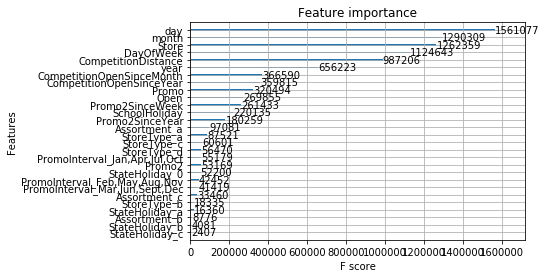

In [81]:
from matplotlib import pyplot
xgb.plot_importance(model)
pyplot.show()